# DoRA - Weight Decomposed Low Rank Adaptation

<ol>
> This notebook contains the code to decompose the pretrained weights and finetuned weights of Llama-2-7B LLM model using DoRA. <br>
> These decomposed weights having magnitude and directional components of Query and Value matrices are utilized to plot the visualizations <br>
> The pretrained model is finetuned on Alpaca Cleaned Instruction dataset <br>
> Checkpoints were stored at every 100 training steps <br>
> Hyper parameters for finetuning are taken from the DoRA research paper <br>
> There are 32 Decoder layers, for better visibility, I have considered layers which are multiples of 6 to plot magnitude and directional components <br>
</ol>
<br>

<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa273632c-9434-43d1-9156-fb6d58a1a26e_1600x1137.png" width=900 height=700/>

### <font color=yellow>*Import all required modules*

In [1]:
import torch
import os

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from peft import PeftModel
from transformers import AutoModelForCausalLM
from peft import get_peft_model, LoraConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

### <font color=yellow>*Load the pretrained Llama-2 7B model into GPU*

In [2]:
def load_model(model_name):
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        device_map="auto"
        )
    model.eval()
    return model

### <font color=yellow>*Decompose the pretrained weights into magnitude and directional components*

<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F6a5bf344-2c27-4197-839f-6c28af722e0f_766x614.png" width=500 height=400>

In [3]:
def weight_decomposition(weights, store: dict, tag=None):
    for i in range(len(weights)):
        magnitude = weights[i].norm(p=2, dim=1, keepdim=True)
        direction = weights[i] / magnitude
        store[f"query_layer_{i}"].append(magnitude)
        store[f"query_layer_{i}"].append(direction)


def get_model_weights(model, tag=None):
    query_weights = []
    for layer in model.model.model.layers:
        query_weights.append(layer.self_attn.q_proj.base_layer.weight)
    return query_weights

### <font color=yellow>*Load the finetuned model (DoRA weights) from checkpoints folder*

In [4]:
model_name = "meta-llama/Llama-2-7b-hf"
peft_name = "trl/output/dora/checkpoint-100"

model = load_model(model_name)
peft_model = PeftModel.from_pretrained(model, peft_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### <font color=yellow>*Verify the shape of weight matrices for Query Vector*
##### <font color=yellow>*Linear layer weights ------> (hidden_dim, hidden_dim)*
##### <font color=yellow>*LoRA - A matrix -----------> (rank, hidden_dim)*
##### <font color=yellow>*LoRA - B matrix -----------> (hidden_dim, rank)*
##### <font color=yellow>*Magnitude Vector ----------> (hidden_dim, 1)*

In [5]:
for module in peft_model.model.model.layers:
    print(f"Shape of Pre-trained Query Layer Weight Matrix -> {module.self_attn.q_proj.weight.shape}")
    print(f"Shape of LoRA - A matrix for Query Layer -> {module.self_attn.q_proj.lora_A.default.weight.shape}")
    print(f"Shape of LoRA - B matrix for Query Layer -> {module.self_attn.q_proj.lora_B.default.weight.shape}")
    print(f"Trainable Magnitude Vector -> {module.self_attn.q_proj.lora_magnitude_vector}")
    break

Shape of Pre-trained Query Layer Weight Matrix -> torch.Size([4096, 4096])
Shape of LoRA - A matrix for Query Layer -> torch.Size([64, 4096])
Shape of LoRA - B matrix for Query Layer -> torch.Size([4096, 64])
Trainable Magnitude Vector -> ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 4096 (cuda:0)])


### <font color=yellow>*Number of Trainable parameters*
> Only 2.33% of parameters are trained <br>
> Only marginal increase compared to LoRA due to addition of trainable magnitude vectors

In [13]:
peft_config = LoraConfig(
    use_dora=True,
    r=64,
    lora_alpha=128,
    lora_dropout=0.0,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 161,267,712 || all params: 6,899,683,328 || trainable%: 2.337320487529482


### <font color=yellow>*Fetch and Store the decomposed weights of Query/ Value matrices of pretrained model*

In [6]:
pretrained_weight_decomposition = defaultdict(list)
pretrained_query_weights = get_model_weights(peft_model)
weight_decomposition(pretrained_query_weights, pretrained_weight_decomposition)

del peft_model

### <font color=yellow>*Helper Functions to compute change in Magnitude and Directional Components*

In [7]:
def merged_dora_weights(layer):
    combined_weights = layer.weight
    return combined_weights


def get_merged_weights(model):
    query_weights = []
    for layer in model.model.layers:
        query_weights.append(merged_dora_weights(layer.self_attn.q_proj))
    return query_weights


def cos_sim(a, b, dim):
    dot_product = torch.sum(a * b, dim=dim)
    norm_A = torch.norm(a, dim=dim)
    norm_B = torch.norm(b, dim=dim)
    sim = dot_product / (norm_A * norm_B)
    return sim


def delta_magnitude(pt_weights, ft_weights):
    layer_wise_delta_m = {}
    for i in range(1, 7):
        a = ft_weights.get(f"query_layer_{i}")[0]
        b = pt_weights.get(f"query_layer_{i}")[0]
        k = b.shape[0]
        d_m = torch.sum(abs(a - b)) / k
        layer_wise_delta_m[f"layer_{i}"] = round(d_m.item(), 6)
    return layer_wise_delta_m


def delta_direction(pt_weights, ft_weights):
    layer_wise_delta_d = {}
    for i in range(1, 7):
        a = ft_weights.get(f"query_layer_{i}")[1]
        b = pt_weights.get(f"query_layer_{i}")[1]
        k = b.shape[0]
        sim = cos_sim(a, b, dim=0)
        d_m = torch.sum(1 - sim) / k
        layer_wise_delta_d[f"layer_{i}"] = round(d_m.item(), 6)
    return layer_wise_delta_d

### <font color=yellow>*Computes the Magnitude and Directional Components of finetuned model checkpoints*

In [8]:
def get_magnitude_directions(tag):
    checkpoint_path = "trl/output/dora"
    artifacts = os.listdir(checkpoint_path)
    combined_dm, combined_dd = defaultdict(list), defaultdict(list)

    for model_dir in artifacts:
        if not model_dir.startswith("."):
            decomposed_weights = defaultdict(list)
            model_path = os.path.join(checkpoint_path, model_dir)
            peft_model = PeftModel.from_pretrained(model, model_path)
            merged_model = peft_model.merge_and_unload()
            query_weights = get_merged_weights(merged_model)
            del peft_model
            del merged_model

            weight_decomposition(query_weights, decomposed_weights, tag=tag)
            dm = delta_magnitude(pretrained_weight_decomposition, decomposed_weights)
            dd = delta_direction(pretrained_weight_decomposition, decomposed_weights)

            name = model_dir[-3:]
            combined_dm[name].append(dm)
            combined_dd[name].append(dd)
    return combined_dm, combined_dd

In [9]:
tag = "dora"
dora_m, dora_d = get_magnitude_directions(tag=tag)

### <font color=yellow>*Accumulate magnitude and direction of each layer for plotting from each checkpoint*

In [10]:
checkpoint_wise_magnitude_direction = []
for model_name in ['300', '400', '500', '600', '700']:
    if model_name in dora_m and model_name in dora_d:
        magnitude, direction = dora_m[model_name], dora_d[model_name]
        layer_wise_magnitude_direction = {}
        for m, d in zip(magnitude[0].items(), direction[0].items()):
            layer_wise_magnitude_direction[m[0]] = {"magnitude": m[1], "direction": d[1]}
        checkpoint_wise_magnitude_direction.append(layer_wise_magnitude_direction)

print(f"Checkpoint Wise Magnitude and Direction -> \n{checkpoint_wise_magnitude_direction[0]}")

Checkpoint Wise Magnitude and Direction -> 
{'layer_1': {'magnitude': 0.004974, 'direction': 0.18793}, 'layer_2': {'magnitude': 0.005409, 'direction': 0.110594}, 'layer_3': {'magnitude': 0.005479, 'direction': 0.120249}, 'layer_4': {'magnitude': 0.005501, 'direction': 0.084277}, 'layer_5': {'magnitude': 0.005378, 'direction': 0.085303}, 'layer_6': {'magnitude': 0.005202, 'direction': 0.094416}}


### <font color=yellow>*Visualization of Magnitude and Directional Components between Pretrained and Finetuned Intermediate Model checkpoints*
> A negative correlation can be observed in below plot <br>
> Since, pretrained model already has gained significant knowledge of the language and it's structure that's needed for downstream tasks, <br>
> Finetuning on simple tasks need alteration on magnitude or direction components but not both for downstream task specific adaptation<br>
> DoRA demonstrates the ability to make only substantial directional adjustments with relatively minimal changes in magnitude or the reverse

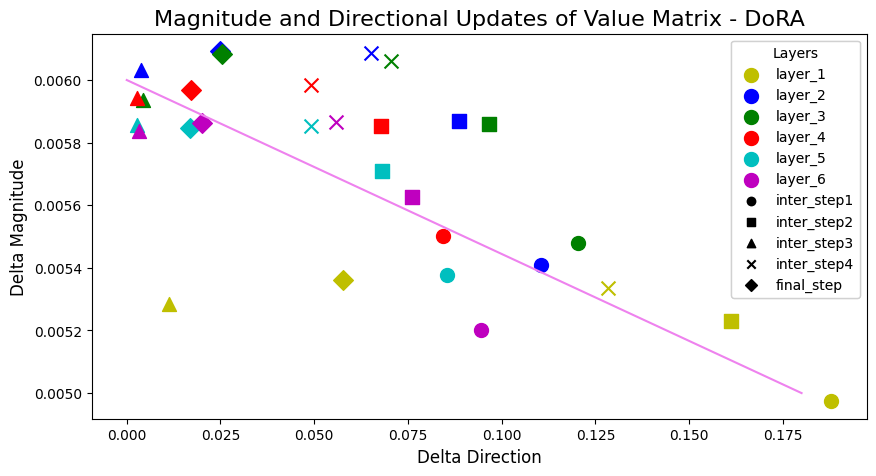

In [14]:
layers = ['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6']
markers = ['o', 's', '^', 'x', 'D']
colors = ['y', 'b', 'g', 'r', 'c', 'm']
marker_labels = ["inter_step1",  "inter_step2", "inter_step3", "inter_step4", "final_step"]

plt.figure(figsize=(10, 5))

for i, layer in enumerate(layers):
    for j, entry in enumerate(checkpoint_wise_magnitude_direction):
        plt.scatter(entry[layer]['direction'], entry[layer]['magnitude'], color=colors[i],
                    label=layer if j == 0 else "", marker=markers[j], s=100)

for i, marker in enumerate(markers):
    plt.scatter([], [], marker=marker, color='k', label=marker_labels[i])

x = np.linspace(0.0, 0.18, 100)
y = np.linspace(0.005, 0.006, 100)[::-1]
plt.plot(x, y, '-', color='violet')

legend_layers = plt.legend(title='Layers', loc='upper right')
plt.gca().add_artist(legend_layers)

plt.xlabel('Delta Direction', fontsize=12)
plt.ylabel('Delta Magnitude', fontsize=12)
plt.title('Magnitude and Directional Updates of Value Matrix - DoRA', fontsize=16)
plt.grid(False)

# plt.savefig('plot_dora_v_proj.jpg', format='jpg')
plt.show()

### <font color=yellow>*Correlation Coefficient between Magnitude and Directional Components*

In [12]:
x, y = [], []

for i, j in dora_m.items():
    if i in ['300', '400', '500', '600', '700']:
        for _, k in j[0].items():
            x.append(k)

for i, j in dora_d.items():
    if i in ['300', '400', '500', '600', '700']:
        for _, k in j[0].items():
            y.append(k)

correlation = np.corrcoef(x, y)
print(f"Correlation Coefficient for DoRA: {round(correlation[0][-1], 2)}")

Correlation Coefficient for DoRA: -0.69
